In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import sys
import numpy as np

sys.path.insert(0, './src/')
from target import NN_bernoulli, GMM_target2
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [3]:
# 'Encoder' - simple matrix
class Encoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Encoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.L, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=self.z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Decoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.z_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.L)
#         self.sigma = nn.Linear(in_features=K, out_features=self.L)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2) #, nn.functional.softplus(self.sigma(h3))

In [4]:
# 'Encoder' - simple matrix
class Encoder_h(nn.Module):
    def __init__(self, L, z_dim, device='cpu'):
        super(Encoder_h, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.mu = nn.Linear(in_features=self.L, out_features=self.z_dim, bias=False)
        self.h = nn.Linear(in_features=self.L, out_features=self.z_dim)
    def forward(self, x):
        return self.mu(x), self.h(x)
    
# 'Encoder' - simple matrix
class Encoder(nn.Module):
    def __init__(self, L, z_dim, device='cpu'):
        super(Encoder, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.mu = nn.Linear(in_features=self.L, out_features=self.z_dim, bias=False)
#         self.sigma = nn.Linear(in_features=self.L, out_features=self.z_dim, bias=False)
    def forward(self, x):
        return self.mu(x) #, F.softplus(self.sigma(x))
    
# 'Decoder' - simple matrix, return logits
class Decoder(nn.Module):
    def __init__(self, L, z_dim, device='cpu'):
        super(Decoder, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.W = nn.Linear(in_features=self.z_dim, out_features=self.L, bias=False)
    def forward(self, z):
        return self.W(z)

In [5]:
L = 2

K = 64
z_dim = 32
N = 200

device = "cuda:1" if torch.cuda.is_available() else "cpu"

args = dotdict({})
args.K = 5
args.N = 5
args.z_dim = z_dim
args.torchType = torch.float32
args.device = device
args.learnable_reverse = True
args.learnable_accept = False
args.num_epoches = 2000
args.train_batch_size = 250
args.amortize = False
args.gamma = 0.1 ## Stepsize
args.alpha = 0.5  ## For partial momentum refresh
args.train_only_inference_period = 10
args.train_only_inference_cutoff = 5
args.hoffman_idea = True
args.separate_params = True
args.use_barker = True


std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
args.std_normal = std_normal

In [6]:
true_theta = std_normal.sample((z_dim, L)) + 5
print('True decoder matrix')
print(true_theta)
print('-' * 75)
data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
# data_probs = torch.sigmoid(torch.ones((N, z_dim), device=device) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()
print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[5.3189, 7.2435],
        [5.6806, 7.0572],
        [2.6775, 5.1204],
        [4.8768, 4.8787],
        [4.7085, 5.3774],
        [5.1964, 6.1653],
        [4.7479, 4.9833],
        [4.8654, 5.5116],
        [5.6821, 4.9821],
        [2.9722, 4.9563],
        [4.3360, 4.2839],
        [5.8539, 6.2256],
        [7.5200, 5.3564],
        [3.1803, 4.7888],
        [4.8208, 3.6435],
        [5.0013, 4.9127],
        [5.5176, 4.8387],
        [4.3219, 5.0528],
        [6.8379, 5.0674],
        [3.1968, 5.1829],
        [5.2501, 3.3492],
        [5.5336, 3.9671],
        [4.4940, 5.0006],
        [5.5344, 4.9686],
        [4.4765, 6.3845],
        [4.2529, 4.9643],
        [5.3504, 5.6725],
        [5.8109, 5.6627],
        [1.7745, 4.7949],
        [5.4638, 3.9977],
        [2.6159, 4.3219],
        [4.3304, 4.9351]], device='cuda:1')
---------------------------------------------------------------------------
Generated data example:
tensor([[0., 0.],
        [0.,

In [7]:
# GMM with arbitraty many components
comp_1 = 1
comp_2 = 0.7
args['num_gauss'] = 8
args['p_gaussians'] = [torch.tensor(1. / args['num_gauss'], device=args.device, dtype=args.torchType)] * args['num_gauss']
args['locs'] = [torch.tensor([0., comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([0., -comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, comp_2], dtype=args.torchType, device=args.device)]  # list of locations for each of these gaussians
args['covs'] = [0.01 * torch.eye(2, dtype=args.torchType, device=args.device)] * args['num_gauss']   # list of covariance matrices for each of these

target = GMM_target2(args, device)
data = target.get_samples(1000)

In [8]:
# plt.scatter(data[:, 0].cpu(), data[:, 1].cpu())
# plt.axis('equal');

In [9]:
dataloader = torch.utils.data.DataLoader(data, batch_size=args.train_batch_size, shuffle=True)

In [13]:
# def potential_fn(z):
#     z = z['points']
# #     pdb.set_trace()
#     potential = -target.get_logdensity(z).sum()
#     return potential
        
    
# init_samples = std_normal.sample((100, 2))
# init_params = {'points': init_samples}

# nuts_kernel = NUTS(potential_fn=potential_fn)
# mcmc = MCMC(nuts_kernel,
#             initial_params=init_params,
#             num_samples=1,
#             warmup_steps=1000)

# mcmc.run()
# z = mcmc.get_samples()['points'].squeeze()

for p in dec.parameters():
    p.requires_grad_(False)

class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
        mu_recovered = dec(z)
        return (torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1))
target = Target()


transitions = HMC_vanilla(args)

z = std_normal.sample((batch_train.shape[0], z_dim))
momentum = std_normal.sample(z.shape)
for i in range(10000):
    z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)

In [14]:
points = dec(z)

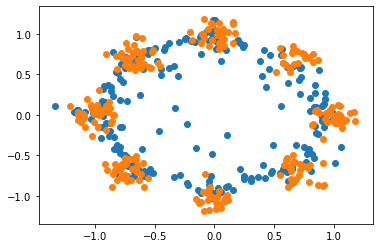

In [16]:
plt.scatter(points[:, 0].cpu(), points[:, 1].cpu())
plt.scatter(batch_train[:, 0].cpu(), batch_train[:, 1].cpu())


## NUTS

In [10]:
# def model():
# #     pdb.set_trace()
#     theta = pyro.sample('theta', dist.Normal(torch.zeros((z_dim, L)), torch.ones((z_dim, L))))
#     z = pyro.sample('z', dist.Normal(torch.zeros((data.shape[0], z_dim)), torch.zeros((data.shape[0], z_dim))))
#     probs = torch.sigmoid(z @ theta)
# #     with pyro.plate('obs_plate'):
#     return pyro.sample("obs", dist.Bernoulli(probs=probs), obs=data)
def potential_fn(z):
    z = z['points']
#     probs = torch.sigmoid(z @ current_matrix)
#     return -torch.sum(torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1))
    mu_recovered = dec(z)
#     pdb.set_trace()
    return -(torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1)).sum()
        

  0%|          | 0/2000 [00:00<?, ?it/s]

-2.3947001099586487


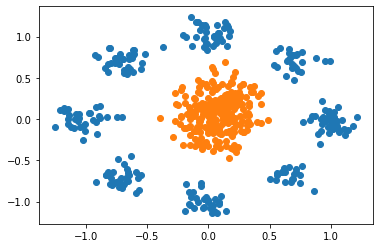

  0%|          | 1/2000 [00:00<07:37,  4.37it/s]

-2.3689345717430115


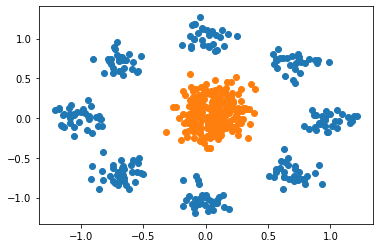

  0%|          | 2/2000 [00:00<07:35,  4.38it/s]

-2.35949045419693


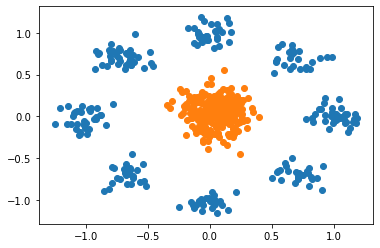

  0%|          | 3/2000 [00:00<07:34,  4.40it/s]

-2.364559769630432


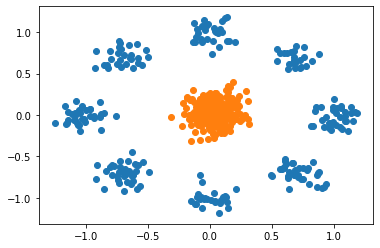

  0%|          | 4/2000 [00:00<07:31,  4.42it/s]

-2.355941891670227


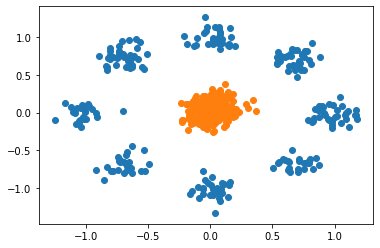

  0%|          | 5/2000 [00:01<07:29,  4.44it/s]

-2.348421275615692


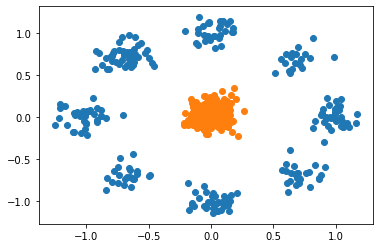

  0%|          | 6/2000 [00:01<07:28,  4.45it/s]

-2.3459752798080444


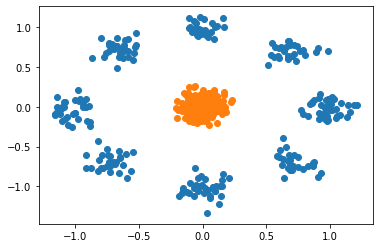

  0%|          | 7/2000 [00:01<07:27,  4.45it/s]

-2.3475789427757263


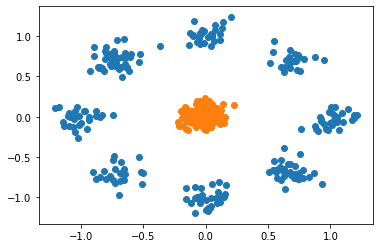

  0%|          | 8/2000 [00:01<07:46,  4.27it/s]

-2.3544694781303406


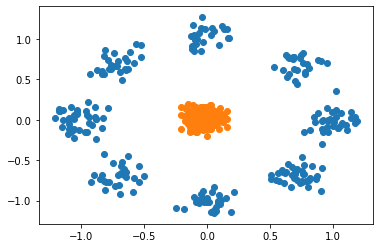

  0%|          | 9/2000 [00:02<07:40,  4.32it/s]

-2.348443925380707


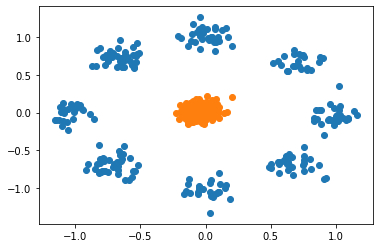

  0%|          | 10/2000 [00:02<07:36,  4.36it/s]

-2.345603048801422


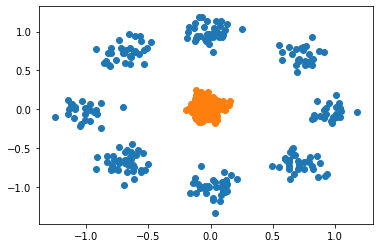

  1%|          | 11/2000 [00:02<07:32,  4.39it/s]

-2.3470418453216553


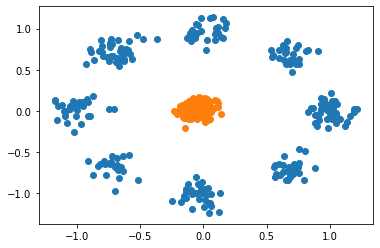

  1%|          | 12/2000 [00:02<07:29,  4.42it/s]

-2.344145953655243


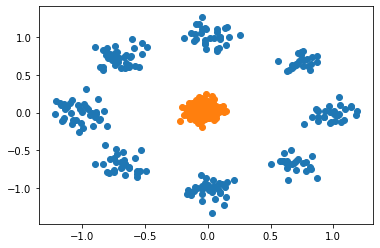

  1%|          | 13/2000 [00:02<07:28,  4.43it/s]

-2.3481040596961975


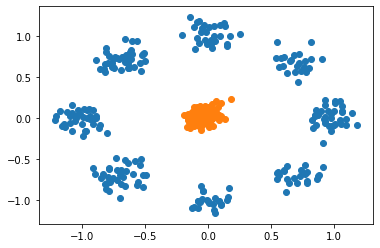

  1%|          | 14/2000 [00:03<07:26,  4.45it/s]

-2.344178259372711


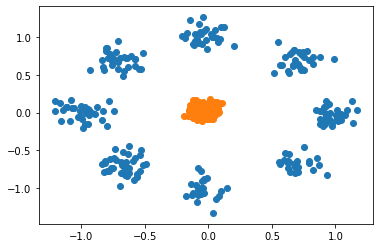

  1%|          | 15/2000 [00:03<07:25,  4.46it/s]

-2.3467984199523926


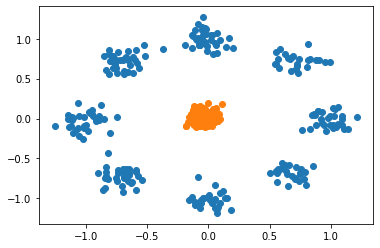

  1%|          | 16/2000 [00:03<07:24,  4.47it/s]

-2.345357835292816


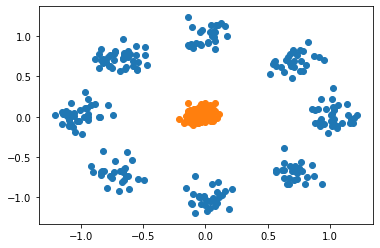

  1%|          | 17/2000 [00:03<07:23,  4.47it/s]

-2.3455840349197388


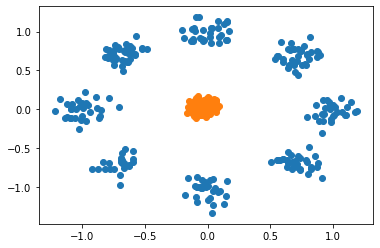

  1%|          | 18/2000 [00:04<07:24,  4.46it/s]

-2.345589518547058


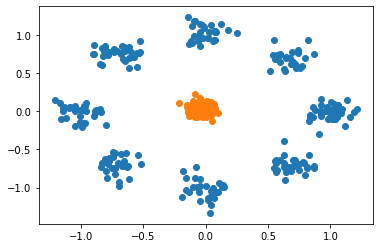

  1%|          | 19/2000 [00:04<07:23,  4.47it/s]

-2.345140814781189


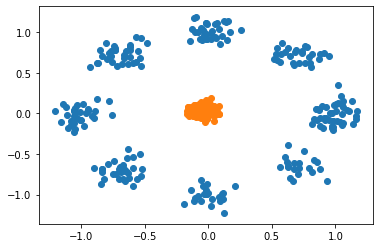

  1%|          | 20/2000 [00:04<07:22,  4.47it/s]

-2.3462822437286377


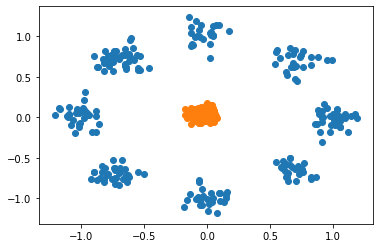

  1%|          | 21/2000 [00:04<07:22,  4.47it/s]

-2.345716118812561


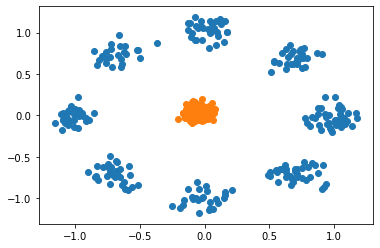

  1%|          | 22/2000 [00:04<07:43,  4.27it/s]

-2.3457823991775513


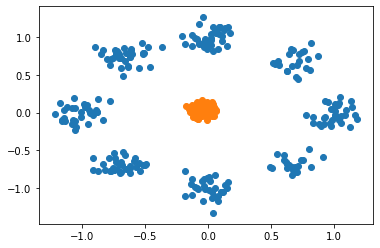

  1%|          | 23/2000 [00:05<07:37,  4.32it/s]

-2.3455249667167664


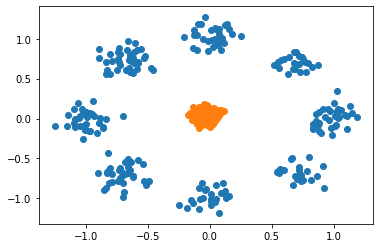

  1%|          | 24/2000 [00:05<07:32,  4.36it/s]

-2.346492111682892


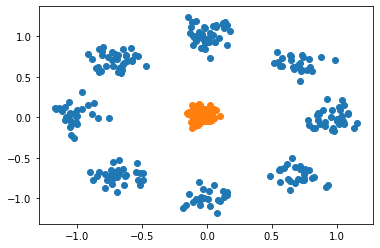

  1%|▏         | 25/2000 [00:05<07:29,  4.40it/s]

-2.3456621766090393


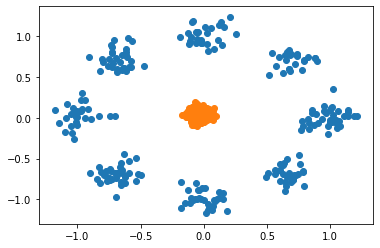

  1%|▏         | 26/2000 [00:05<07:26,  4.42it/s]

-2.3441015481948853


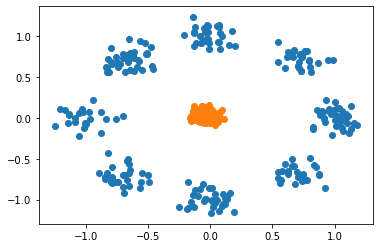

  1%|▏         | 27/2000 [00:06<07:24,  4.44it/s]

-2.3436743021011353


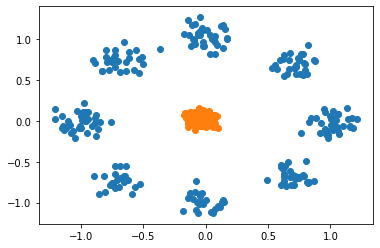

  1%|▏         | 28/2000 [00:06<07:22,  4.45it/s]

-2.3456058502197266


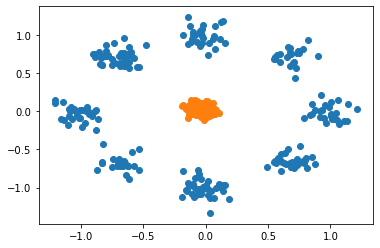

  1%|▏         | 29/2000 [00:06<07:21,  4.46it/s]

-2.3444026708602905


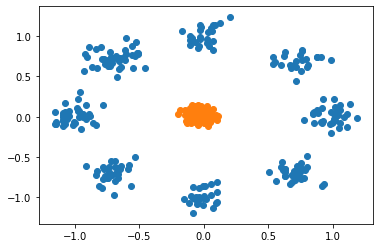

  2%|▏         | 30/2000 [00:06<07:21,  4.47it/s]

-2.3448670506477356


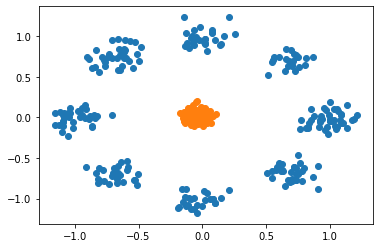

  2%|▏         | 31/2000 [00:07<07:20,  4.47it/s]

-2.345447063446045


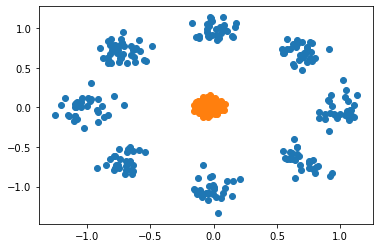

  2%|▏         | 32/2000 [00:07<07:20,  4.47it/s]

-2.3458537459373474


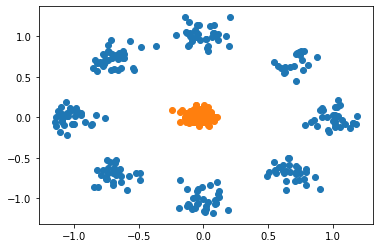

  2%|▏         | 33/2000 [00:07<07:19,  4.47it/s]

-2.3466432094573975


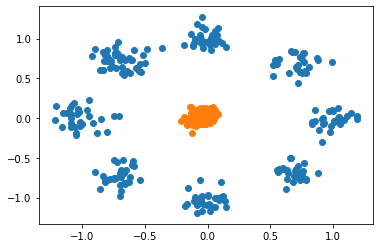

  2%|▏         | 34/2000 [00:07<07:19,  4.47it/s]

-2.344128370285034


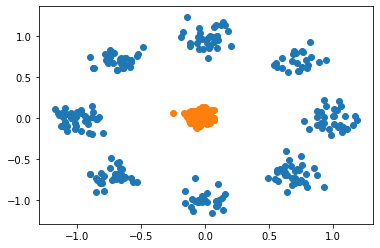

  2%|▏         | 35/2000 [00:07<07:19,  4.48it/s]

-2.346600890159607


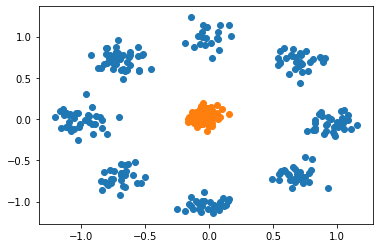

  2%|▏         | 36/2000 [00:08<07:39,  4.27it/s]

-2.3422539830207825


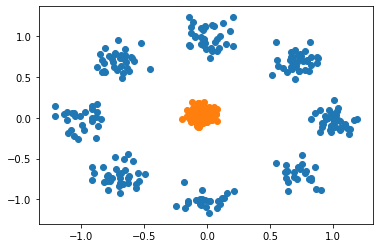

  2%|▏         | 37/2000 [00:08<07:33,  4.32it/s]

-2.3450052738189697


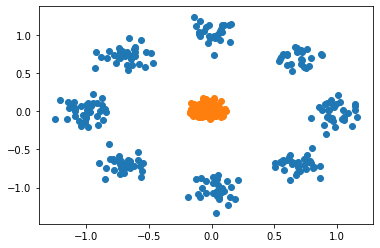

  2%|▏         | 38/2000 [00:08<07:29,  4.36it/s]

-2.3430376052856445


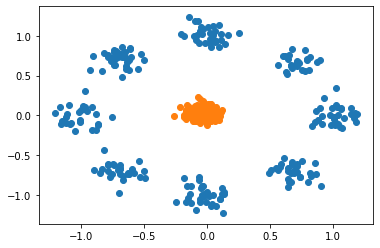

  2%|▏         | 39/2000 [00:08<07:26,  4.40it/s]

-2.3439547419548035


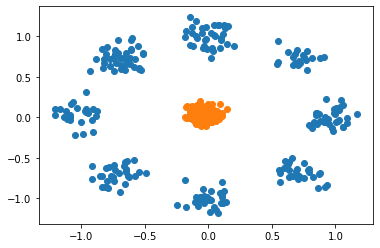

  2%|▏         | 40/2000 [00:09<07:23,  4.41it/s]

-2.3466853499412537


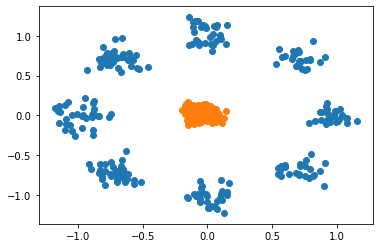

  2%|▏         | 41/2000 [00:09<07:21,  4.43it/s]

-2.3465004563331604


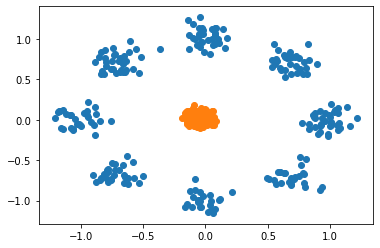

  2%|▏         | 42/2000 [00:09<07:20,  4.45it/s]

-2.3420426845550537


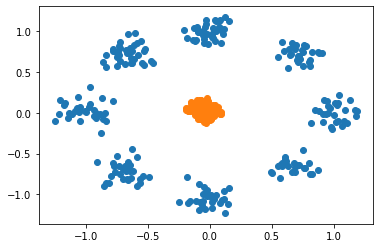

  2%|▏         | 43/2000 [00:09<07:19,  4.46it/s]

-2.34720641374588


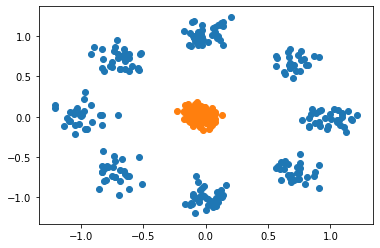

  2%|▏         | 44/2000 [00:09<07:17,  4.47it/s]

-2.3457327485084534


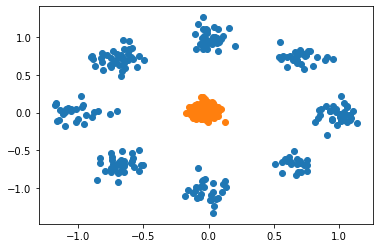

  2%|▏         | 45/2000 [00:10<07:17,  4.47it/s]

KeyboardInterrupt: 

In [19]:
# dec = Decoder(L=L, z_dim=z_dim).to(device)
dec = Decoder_vae(L=L, z_dim=z_dim).to(device)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

print_info_ = 1
n_samples = 1

transitions = HMC_vanilla(args)

class Target():
    def __init__(self,):
        pass
    def get_logdensity(self, z, x):
#         pdb.set_trace()
        mu_recovered = dec(z)
        return (torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1))

target = Target()
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    plt.close()
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        init_samples = std_normal.sample((batch_train.shape[0], z_dim))
        momentum = std_normal.sample((batch_train.shape[0], z_dim))
        z = init_samples
#         pdb.set_trace()
        for p in dec.parameters():
            p.requires_grad_(False)
            
#         pdb.set_trace()
        for _ in range(args.K):
            z, momentum, _, _, _, _ = transitions.make_transition(z, momentum, target, x=batch_train)
            
            
        for p in dec.parameters():
            p.requires_grad_(True)
#         init_params = {'points': init_samples}
        
#         current_matrix = dec.W.weight.detach().T
        
#         nuts_kernel = NUTS(potential_fn=potential_fn)
#         mcmc = MCMC(nuts_kernel,
#                     initial_params=init_params,
#                     num_samples=n_samples,
#                     warmup_steps=1)
        

#         mcmc.run()
#         z = mcmc.get_samples()['points'][-n_samples:]

        
#         pdb.set_trace()
#         probs = torch.sigmoid(dec(z))
#         obj = torch.mean((torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean(0).sum(1)))
        mu_recovered = dec(z)
        obj = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean()
#         obj = (torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).sum(1)).mean()
        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
    scheduler.step(obj)
    if ep % print_info_ == 0:
        print(obj_sum / j)
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
#         plt.scatter(mu_recovered.cpu().detach().numpy()[-1, :, 0], mu_recovered.cpu().detach().numpy()[-1, :, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()

In [13]:
(torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean(0).sum(1)).mean()

tensor(-2.3831, device='cuda:1', grad_fn=<MeanBackward0>)

In [15]:
(torch.distributions.Normal(loc=batch_train, scale=torch.ones_like(batch_train)).log_prob(batch_train).sum(1)).mean()

tensor(-1.8379, device='cuda:1')

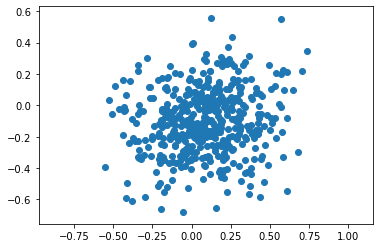

In [20]:
u = args.std_normal.sample((500, args.z_dim)) # sample random tensor for reparametrization trick
batch_recovered = dec(u).cpu().detach().numpy()

plt.scatter(batch_recovered[:, 0], batch_recovered[:, 1])
plt.axis('equal');

In [ ]:
# target_samples = torch.cat([target_samples, mcmc.get_samples()['points']], dim=0)
# target_samples = target_samples.squeeze().cpu()

print(mcmc.get_samples()['points'][-1])
print(true_theta)

In [ ]:
test = torch.arange(30).view(3, 5, 2)
test

In [ ]:
test.view(3, 10).view()

## VAE

  0%|          | 0/2000 [00:00<?, ?it/s]

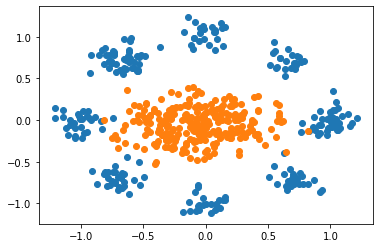

  0%|          | 10/2000 [00:00<01:25, 23.24it/s]

elbo: -1.2509723901748657


 25%|██▍       | 498/2000 [00:07<00:21, 71.52it/s]

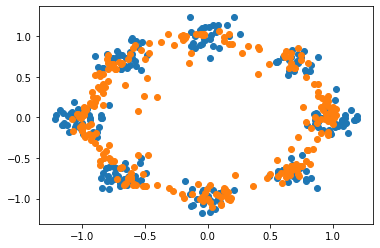

 26%|██▌       | 514/2000 [00:07<00:23, 62.52it/s]

elbo: -1.0063698291778564


 50%|████▉     | 994/2000 [00:14<00:13, 71.99it/s]

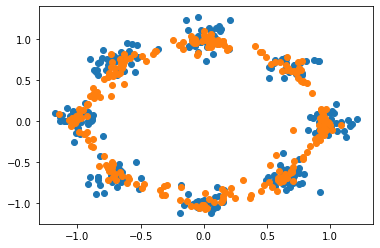

 50%|█████     | 1010/2000 [00:14<00:15, 63.03it/s]

elbo: -1.0026752948760986


 75%|███████▍  | 1498/2000 [00:21<00:06, 72.68it/s]

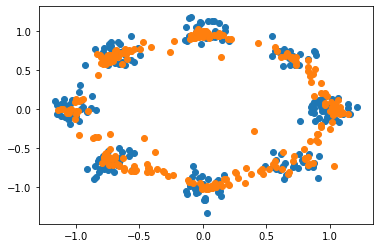

 76%|███████▌  | 1514/2000 [00:21<00:07, 63.58it/s]

elbo: -1.0008935928344727


100%|██████████| 2000/2000 [00:28<00:00, 71.27it/s]


In [10]:
enc = Encoder_vae(L=L, z_dim=z_dim).to(device)
dec = Decoder_vae(L=L, z_dim=z_dim).to(device)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
args.std_normal = std_normal

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=1e-3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500, 2000, 2500,
#                                                                        3000, 3500, 4000, 4500], gamma=0.9) #torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')


print_info_ = 500
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    plt.close()
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()   
        mu, sigma = enc(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick
        
        mu_recovered = dec(z)
        log_likelihood = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean()
#         log_likelihood = torch.distributions.Bernoulli(probs=torch.sigmoid(mu_recovered)).log_prob(batch_train).sum(1)
    
#         sum_log_sigma = torch.sum(torch.log(sigma), 1)
#         log_prior = std_normal.log_prob(z).sum(1)
#         log_q = std_normal.log_prob((z - mu) / sigma).sum(1) - sum_log_sigma
#         elbo = torch.mean(log_likelihood + log_prior - log_q)

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step(elbo)
    if ep % print_info_ == 0:
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()
        print('elbo:', elbo.cpu().detach().item())

In [11]:
print(dec.W.weight.T)
print(true_theta)

AttributeError: 'Decoder_vae' object has no attribute 'W'

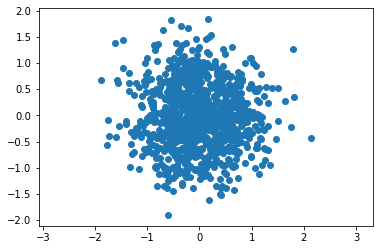

In [12]:
u = args.std_normal.sample((1000, args.z_dim)) # sample random tensor for reparametrization trick
batch_recovered = dec(u).cpu().detach().numpy()

plt.scatter(batch_recovered[:, 0], batch_recovered[:, 1])
plt.axis('equal');

In [ ]:
[p for p in optimizer.parameters()]

In [5]:
if args.learnable_reverse:
    enc = Encoder_h(L=L, z_dim=z_dim, device=device).to(device)
else:
    enc = Encoder(L=L, z_dim=z_dim, device=device).to(device)
dec = Decoder(L=L, z_dim=z_dim, device=device).to(device)
reverse_kernel = Reverse_kernel(args).to(device)
target = NN_bernoulli({}, dec, device).to(device)
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])

In [7]:
if args.learnable_reverse:
    reverse_params = list(reverse_kernel.parameters())
else:
    reverse_params = list([])
    
if args.learnable_accept:
    accept_func = Accept_func(kwargs=args).to(args.device)
    accept_params = accept_func.parameters()
else:
    accept_params = list([])

if args.separate_params:
    params_inference = list(enc.parameters()) + list(reverse_kernel.parameters()) + list(transitions.parameters()) + accept_params
    optimizer = torch.optim.Adam(params=target.parameters())
    optimizer_inference = torch.optim.Adam(params=params_inference)
else:
    params = list(enc.parameters()) + list(target.parameters()) + list(transitions.parameters()) + reverse_params + accept_params
    optimizer = torch.optim.Adam(params=params)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400], gamma=0.5) #torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1)

In [8]:
enc.mu.weight

Parameter containing:
tensor([[-0.2717, -0.6099],
        [-0.5089, -0.2191]], requires_grad=True)

In [9]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma=0., mu=None, all_directions=None, h=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), h=h.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = -args.K * torch.tensor(np.log(2.), device=device)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
        
    log_p = target.get_logdensity(z=z_new, x=x, args=args) + args.std_normal.log_prob(p_new.sum(1))
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo 

In [10]:
print_info_ = 500

for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        if args.learnable_reverse:
            mu, h = enc(batch_train) # sample mu and sigma from encoder
        else:
            mu = enc(batch_train) # sample mu and sigma from encoder
            h = None
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u # reperametrization trick

        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for _ in range(args.K)]

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
#                     pdb.set_trace()
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                    p_old=p, k=cond_vectors[k], target_distr=target, args=args)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target, args=args) # sample a_i -- directions
            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        data.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            # Accumulate alphas
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        ##############################################
        if args.hoffman_idea:
            if args.learnable_reverse:
                log_r = reverse_kernel(z_fin=z.detach(), h=h.detach(), a=all_directions)
                log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
            else:
                log_r = -args.K * torch_log_2
                log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
            log_p = target.get_logdensity(z=z, x=batch_train, args=args) + args.std_normal.log_prob(p.sum(1))
            elbo_full = log_p + log_r - log_m
    #                 pdb.set_trace()
            ### Gradient of the first objective:
#             target.eval()
            obj_1 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
            (-obj_1).backward(retain_graph=True)
            optimizer_inference.step()
            optimizer_inference.zero_grad()
            optimizer.zero_grad() 

            ### Gradient of the second objective:
#             target.train()
            log_p = target.get_logdensity(z=z.detach(), x=batch_train, args=args) + args.std_normal.log_prob(p.detach()).sum(1)
            obj_2 = torch.mean(log_p)
            (-obj_2).backward()
            optimizer.step()
            optimizer_inference.zero_grad()
            optimizer.zero_grad()
            ###########################################################
        else:
            elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                sum_log_jac=sum_log_jacobian, mu=mu,
                                                all_directions=all_directions, h=h)
            (-grad_elbo).backward()

                
        if args.separate_params: # if we separate params of inference part and generation part
            optimizer_inference.step() # we always perform step for inference part
            if ep % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                optimizer.step()
            optimizer.zero_grad()
            optimizer_inference.zero_grad()
        else:
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()
            
        if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
            if args.hoffman_idea:
                print('obj_1:', obj_1)
                print('obj_2:', obj_2)
            else:
                print('elbo:', elbo_full.mean().cpu().detach().item())

  0%|          | 13/5000 [00:00<01:22, 60.14it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.56 and for +1: 0.44
On batch number 1/2 and on k = 2 we have for  0: 0.48 and for +1: 0.52
obj_1: tensor(1.3110, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.4289, grad_fn=<MeanBackward0>)


 10%|█         | 512/5000 [00:07<01:03, 70.84it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.32 and for +1: 0.68
On batch number 1/2 and on k = 2 we have for  0: 0.56 and for +1: 0.44
obj_1: tensor(0.4931, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.1133, grad_fn=<MeanBackward0>)


 20%|██        | 1007/5000 [00:14<00:56, 70.80it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.48 and for +1: 0.52
On batch number 1/2 and on k = 2 we have for  0: 0.52 and for +1: 0.48
obj_1: tensor(0.3981, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.4428, grad_fn=<MeanBackward0>)


 30%|███       | 1513/5000 [00:21<00:49, 70.29it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.52 and for +1: 0.48
On batch number 1/2 and on k = 2 we have for  0: 0.54 and for +1: 0.46
obj_1: tensor(0.2315, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.9668, grad_fn=<MeanBackward0>)


 40%|████      | 2012/5000 [00:28<00:39, 74.87it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.5 and for +1: 0.5
On batch number 1/2 and on k = 2 we have for  0: 0.54 and for +1: 0.46
obj_1: tensor(0.2556, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.9195, grad_fn=<MeanBackward0>)


 50%|█████     | 2508/5000 [00:34<00:33, 75.16it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.64 and for +1: 0.36
On batch number 1/2 and on k = 2 we have for  0: 0.42 and for +1: 0.58
obj_1: tensor(0.2367, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.2249, grad_fn=<MeanBackward0>)


 60%|██████    | 3012/5000 [00:41<00:26, 75.05it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.5 and for +1: 0.5
On batch number 1/2 and on k = 2 we have for  0: 0.6 and for +1: 0.4
obj_1: tensor(0.2640, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.9882, grad_fn=<MeanBackward0>)


 70%|███████   | 3508/5000 [00:48<00:19, 75.18it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.5 and for +1: 0.5
On batch number 1/2 and on k = 2 we have for  0: 0.52 and for +1: 0.48
obj_1: tensor(0.2268, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.8993, grad_fn=<MeanBackward0>)


 80%|████████  | 4012/5000 [00:55<00:13, 74.65it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.56 and for +1: 0.44
On batch number 1/2 and on k = 2 we have for  0: 0.42 and for +1: 0.58
obj_1: tensor(0.1106, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.8914, grad_fn=<MeanBackward0>)


 90%|█████████ | 4508/5000 [01:01<00:06, 70.66it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.56 and for +1: 0.44
On batch number 1/2 and on k = 2 we have for  0: 0.42 and for +1: 0.58
obj_1: tensor(0.1705, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.8818, grad_fn=<MeanBackward0>)


100%|██████████| 5000/5000 [01:08<00:00, 72.80it/s]


In [11]:
target.decoder.W.weight.T

tensor([[-0.0561,  0.0124],
        [-0.4709,  0.4122]], grad_fn=<PermuteBackward>)

In [12]:
target.decoder.W.bias

In [13]:
print(true_theta)

tensor([[-0.9196,  1.2161],
        [ 1.1737, -0.9498]])


In [14]:
enc.mu.weight

Parameter containing:
tensor([[-0.0286,  0.0149],
        [-0.4285,  0.3998]], requires_grad=True)

In [19]:
dec.d.weight.T

tensor([[-0.0039, -0.0011],
        [-0.0083, -0.0068]], grad_fn=<PermuteBackward>)

In [20]:
dec.d.bias

In [21]:
print(true_theta)

tensor([[0.6969, 0.2562],
        [0.7179, 0.3912]])


In [22]:
for b_num, batch_train in enumerate(dataloader): # cycle over batches
    mu = enc(batch_train) # sample mu and sigma from encoder
    u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
    z = mu + u # reperametrization trick
    break

In [23]:
batch_train[:10]

tensor([[1., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [0., 0.]])

In [24]:
torch.distributions.Bernoulli(probs=torch.sigmoid(dec(z[:10]))).sample()

tensor([[1., 1.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.]])

In [5]:
import os
import torch
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

sys.path.insert(0, './recommender/src')
%matplotlib inline
from metrics import NDCG_binary_at_k_batch, Recall_at_k_batch
from models import MultiVAE, MultiDAE, Multi_our_VAE, MultiHoffmanVAE, Multi_ourHoffman_VAE
from training import train_model
from data import Dataset
from args import get_args
import numpy as np
import pandas as pd

import pdb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import ncvis
import re
import gc

device = 'cpu'

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [6]:
class Target(nn.Module):
    def __init__(self, dec, device='cpu'):
        super(Target, self).__init__()
        self.decoder = dec
        self.prior = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                                scale=torch.tensor(1., device=device, dtype=torch.float32))

    def get_logdensity(self, x, z, prior=None, args=None, prior_flow=None):
        """
        The method returns target logdensity
        Input:
        x - datapoint
        z - latent vaiable
        Output:
        log_density - log p(x, z)
        """
        logits = self.decoder(z)
        log_softmax_var = nn.LogSoftmax(dim=-1)(logits)
        log_density = torch.sum(log_softmax_var * x, dim=1) + self.prior.log_prob(z).sum(1)
        return log_density

In [ ]:
class Multi_our_VAE(nn.Module):
    def __init__(self, encoder, decoder, args=None):
        super(Multi_our_VAE, self).__init__()

        ## Define encoder
        self.encoder = encoder(L=2, z_dim=32)
        print(self.encoder)

        ## Define target(decoder)
        decoder = decoder(L=2, z_dim=32)
        print(decoder)
        self.target = Target(dec=decoder, device=args.device)

        ## Define transitions
        self.K = args.K
        self.transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])

        ## Define reverse kernel (if it is needed)
        self.learnable_reverse = args.learnable_reverse
        if args.learnable_reverse:
            self.reverse_kernel = Reverse_kernel(kwargs=args).to(args.device)

        self.dropout = nn.Dropout()

        device_zero = torch.tensor(0., dtype=torch.float32, device=args.device)
        device_one = torch.tensor(1., dtype=torch.float32, device=args.device)
        self.std_normal = torch.distributions.Normal(loc=device_zero, scale=device_one)
        self.torch_log_2 = torch.tensor(np.log(2), device=args.device, dtype=args.torchType)

    def forward(self, x_initial, is_training_ph=1.):
        l2 = torch.sum(x_initial ** 2, 1)[..., None]
        x_normed = x_initial / torch.sqrt(torch.max(l2, torch.ones_like(l2) * 1e-12))
        x = self.dropout(x_normed)

        enc_out = self.encoder(x)
        mu, logvar = enc_out[:, :self.q_dims[-1]], enc_out[:, self.q_dims[-1]:]
        std = torch.exp(0.5 * logvar)
        sum_log_sigma = torch.log(std).sum(1)
        sum_log_alpha = torch.zeros_like(mu[:, 0])
        sum_log_jacobian = torch.zeros_like(mu[:, 0])

        u = self.std_normal.sample(mu.shape)
        z = mu + is_training_ph * u * std

        p_old = self.std_normal.sample(z.shape)
        p_ = p_old.detach()

        if self.learnable_reverse:
            all_directions = torch.tensor([], device=x.device)
        else:
            all_directions = None

        for i in range(self.K):
            cond_vector = self.std_normal.sample(p_.shape)
            z, p_, log_jac, current_log_alphas, directions, _ = self.transitions[i].make_transition(q_old=z, x=x,
                                                                                                    p_old=p_,
                                                                                                    k=cond_vector,
                                                                                                    target_distr=self.target)
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac
            if self.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)

        ## logdensity of Variational family
        log_q = self.std_normal.log_prob(u).sum(1) + self.std_normal.log_prob(p_old).sum(
            1) - sum_log_jacobian - sum_log_sigma + sum_log_alpha

        ## logdensity of prior
        log_priors = self.std_normal.log_prob(z).sum(1) + self.std_normal.log_prob(p_).sum(1)

        ## logits
        logits = self.target.decoder(z)

        ## logdensity of reverse (if needed)
        if self.learnable_reverse:
            log_r = self.reverse_kernel(z_fin=z.detach(), h=mu.detach(), a=all_directions)
        else:
            log_r = -self.K * self.torch_log_2

        return logits, log_q, log_priors, log_r, sum_log_alpha, all_directions
